# K-Means

## Initialization

The first thing we do for each algorithm will be to try to use it without thinking, just decide a subset of feature based on the undestanding and analysis.

In [1]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with.
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this is a classic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utility.cluster_utility import scale_data, inverse_scale_data
from utility.cluster_utility import k_search


# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyclysts_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')
print(cyclysts_df.columns)
print(races_df.columns)

Index(['_url', 'name', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points'],
      dtype='object')
Index(['_url', 'stage', 'name', 'stage_type', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist', 'cyclist_age', 'is_tarmac', 'delta', 'time', 'steepness',
       'season', 'is_staged', 'race_country', 'norm_points',
       'age_performance_index', 'quality_adjusted_points', 'normalized_length',
       'normalized_quality', 'normalized_steepness', 'profile_adjustment',
       'stamina_index'],
      dtype='object')


Now we decide on which features we can do the clustering

**TODO** Read the markdown comment (not if you are a professor please)
<!-- ??It is important for clustering to do not use binary/cathegorical feature?? -->
<!-- ??Should we consider splitting in training and validation?? -->
<!-- Should we study theory before start programming?
    Yes for sure, but we don't have much time :( -->

In [2]:
# We will start by keeping all the numerical columns and see where this brings us.
cyclysts_df = cyclysts_df.select_dtypes(include=[np.number])
# drop the rows with missing values
initial_count = cyclysts_df.shape[0]
cyclysts_df = cyclysts_df.dropna()
final_count = cyclysts_df.shape[0]
print(f'Dropped {initial_count - final_count} rows with missing values')
print(f'In percentage: {(initial_count - final_count) / initial_count * 100}%')
print(cyclysts_df.columns)

Dropped 3061 rows with missing values
In percentage: 49.902184545158136%
Index(['birth_year', 'weight', 'height', 'bmi', 'race_count', 'total_points'], dtype='object')


Probably we want to remove columns with too high correlation, for example it may not be a good idea to have: weight, height, and bmi

## Normalization

In [4]:
cyc_normalizer, cyc_normalized = scale_data(cyclysts_df)

## Hyperparameter

Now we do the classic plot with the various k 

_Warning_: it is obviously slow, but what can I do?

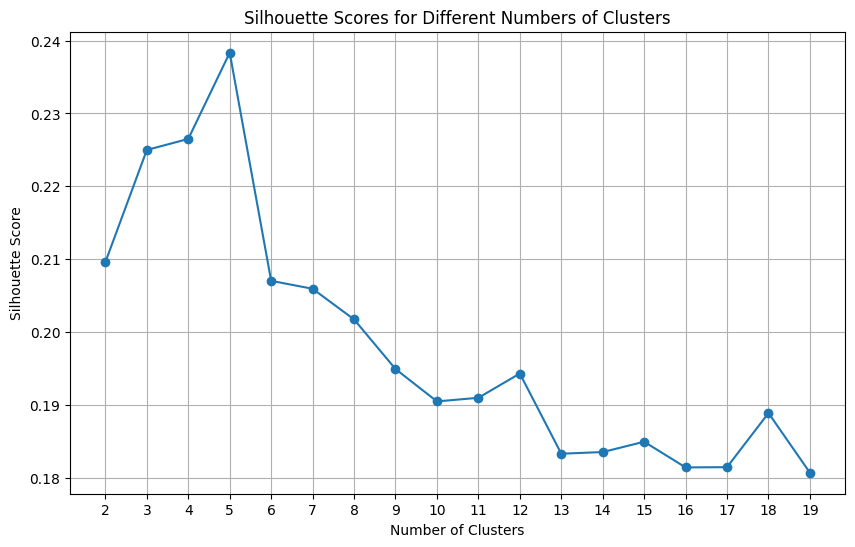

In [5]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 10         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

## Analysis of the best result

Based on magic we can say that 10 is a good number of clusters. So we try to rerun the algorithm with the best parameters and then we will be able to analize a bit the results

**TODO**: To define the best number of clusters just look at the plot and see when it start impoving slowly

In [6]:
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=N_INIT)
kmeans.fit(cyc_normalized)
cyclysts_df['cluster'] = kmeans.labels_
#sns.scatterplot(data=cyclysts_df, x="total_points", y="weight", hue=kmeans.labels_)

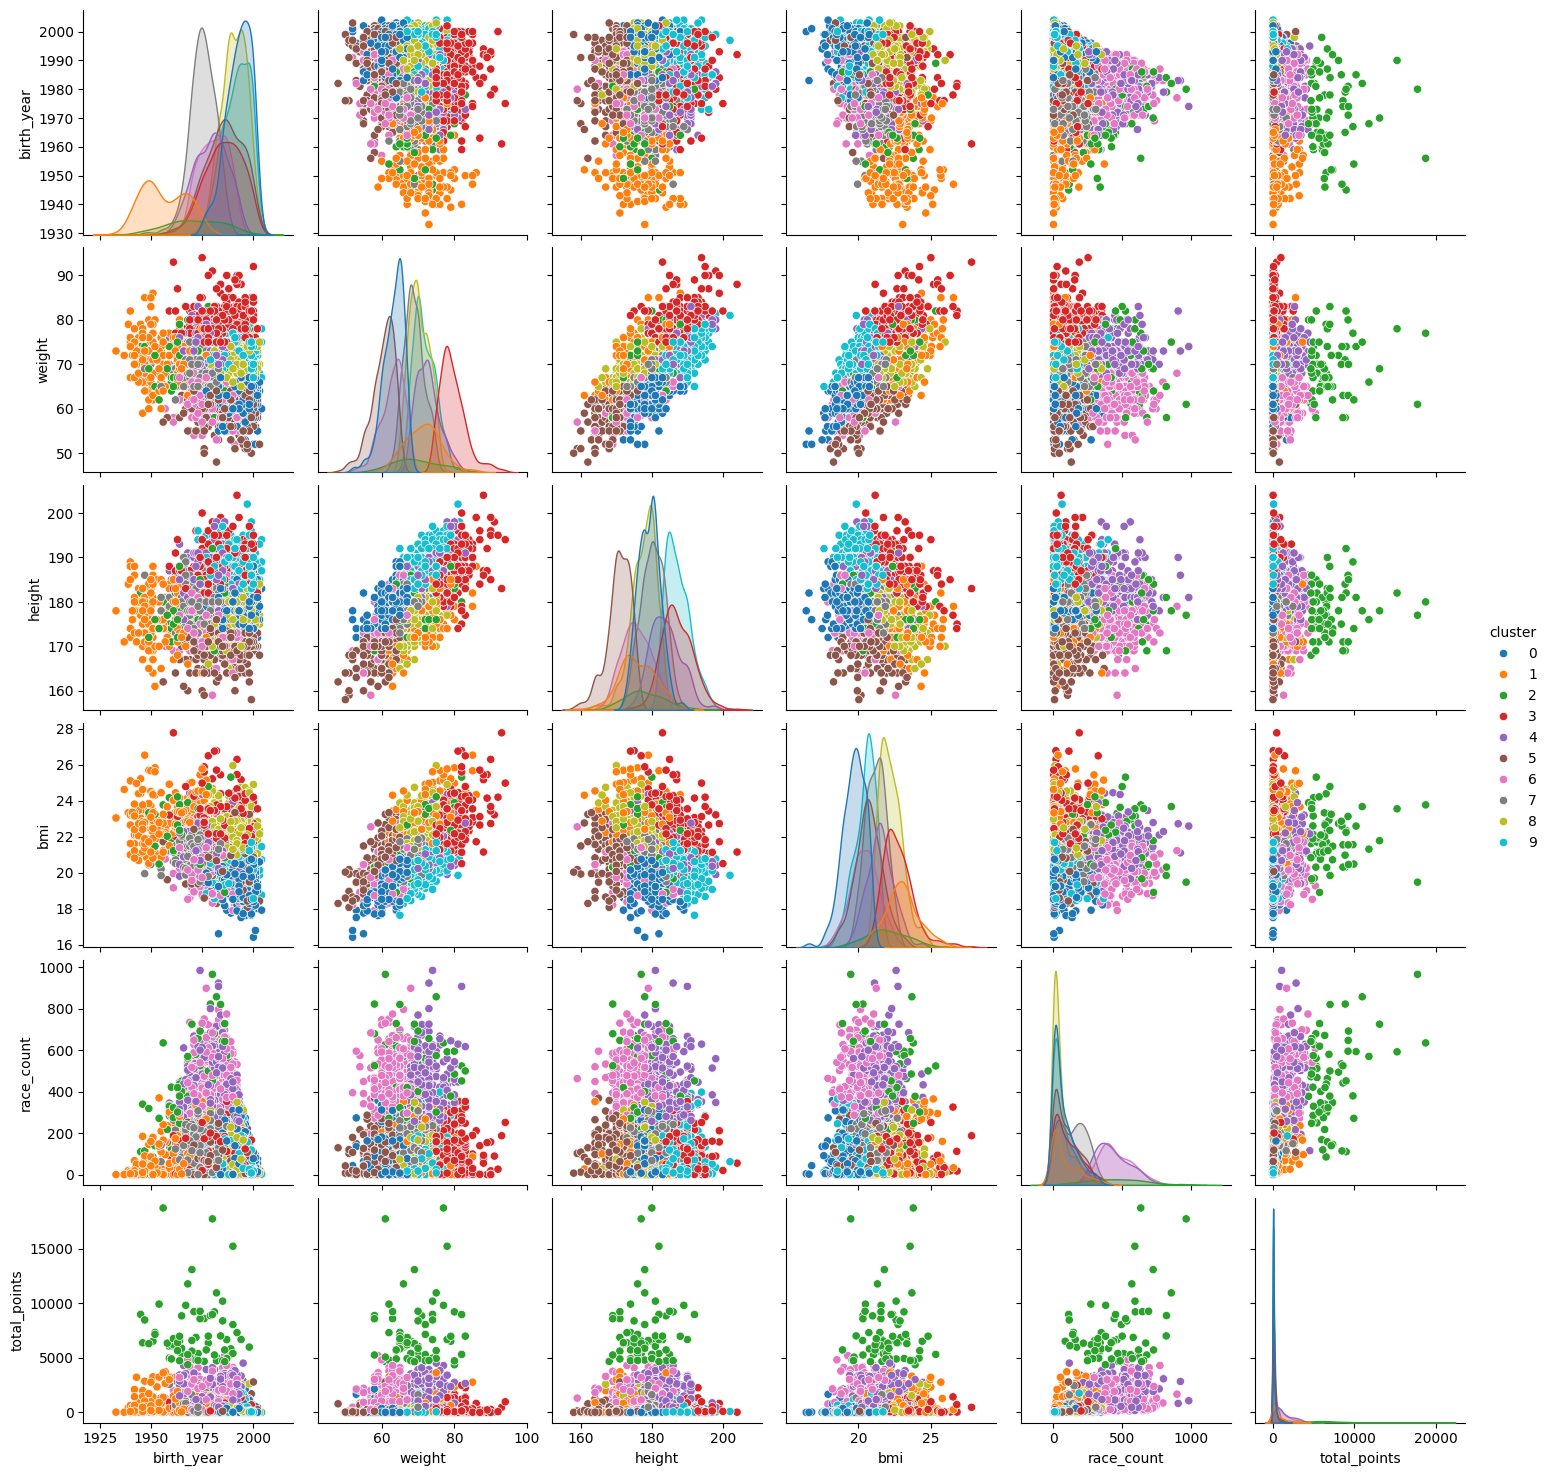

In [7]:
sns.pairplot(cyclysts_df, hue='cluster', palette='tab10')
plt.show()


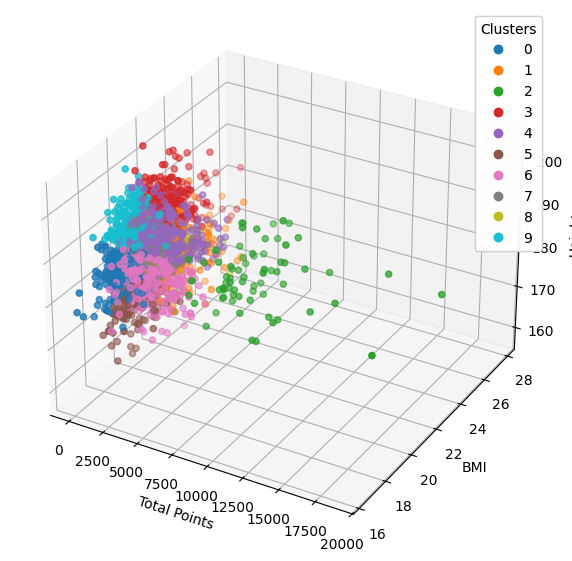

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(cyclysts_df['total_points'], cyclysts_df['bmi'], cyclysts_df['height'], c=cyclysts_df['cluster'], cmap='tab10')

# Labels
ax.set_xlabel('Total Points')
ax.set_ylabel('BMI')
ax.set_zlabel('Height')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

The analysis looks impossible; probably we should remove the outliers of total points because the only meaningful division seems to be that one. But also we will try to remove some redundant columns

## Improvements based on outcome

In [9]:
columns_to_remove = ['birth_year', 'height', 'weight']
small_cyc_df = cyclysts_df.drop(columns=columns_to_remove)
cyc_normalizer, cyc_normalized = scale_data(small_cyc_df)
print(small_cyc_df.columns)

Index(['bmi', 'race_count', 'total_points', 'cluster'], dtype='object')


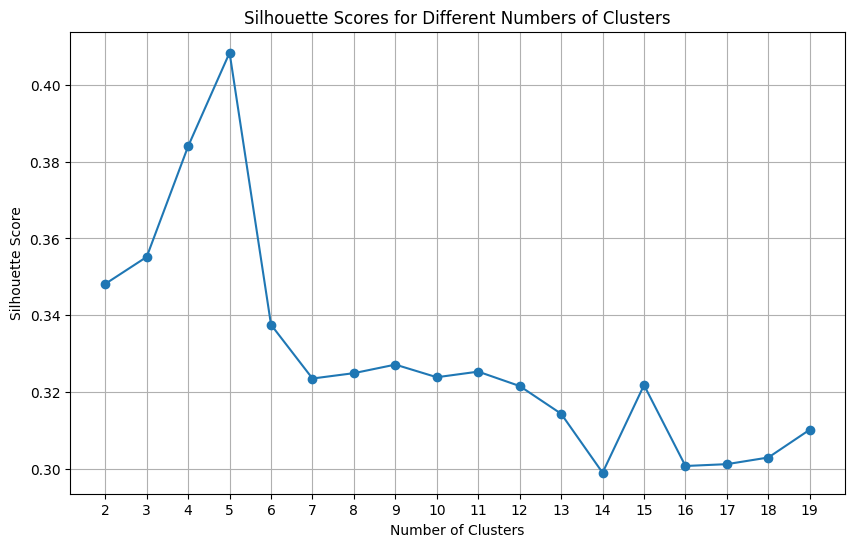

In [10]:
MAX_CLUSTERS = 20   # all the cluster numbers we want to try (from 2 to MAX_CLUSTERS)
N_INIT = 15         # Number of time the k-means algorithm will be run with different centroid seeds.
if RUN_SLOW_STUFF:
    silhouettes = k_search(max_clusters=MAX_CLUSTERS, n_init=N_INIT, data=cyc_normalized)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, MAX_CLUSTERS), silhouettes, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, MAX_CLUSTERS))  # Set x-axis ticks to be integers
    plt.grid(True)
    plt.show()

Boh... 7?

In [12]:
kmeans = KMeans(n_clusters=7, random_state=RANDOM_STATE, n_init=N_INIT)
kmeans.fit(cyc_normalized)
small_cyc_df['cluster'] = kmeans.labels_

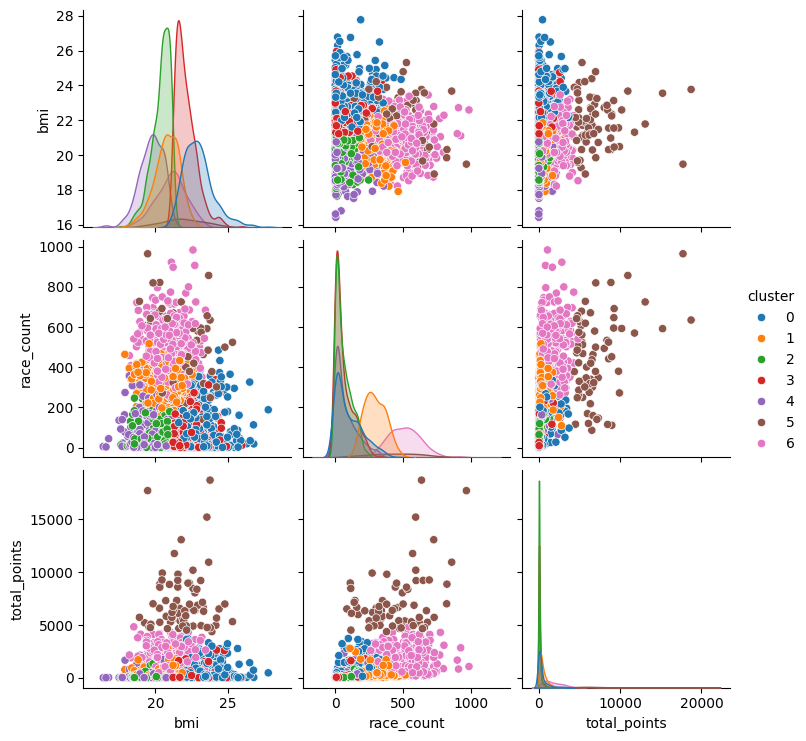

In [25]:
# Inverse transform the cluster centers
centers = cyc_normalizer.inverse_transform(kmeans.cluster_centers_)

# Pairplot with centers
pairplot = sns.pairplot(small_cyc_df, hue='cluster', palette='tab10')
plt.show()

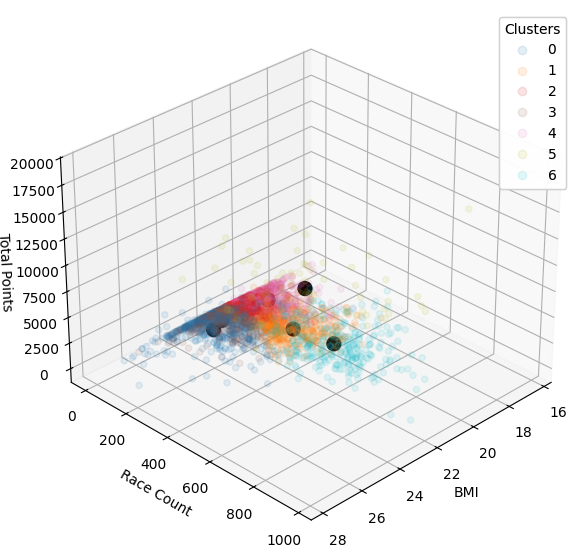

In [26]:
# 3D scatter plot with centers
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(small_cyc_df['bmi'], 
                     small_cyc_df['race_count'], 
                     small_cyc_df['total_points'], 
                     c=small_cyc_df['cluster'], cmap='tab10', alpha=0.1)

# Plot centers
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=100, alpha=1, label='Centers')

# Labels
ax.set_xlabel('BMI')
ax.set_ylabel('Race Count')
ax.set_zlabel('Total Points')

# Rotate the plot
ax.view_init(elev=30, azim=45)  # Adjust the values as needed

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

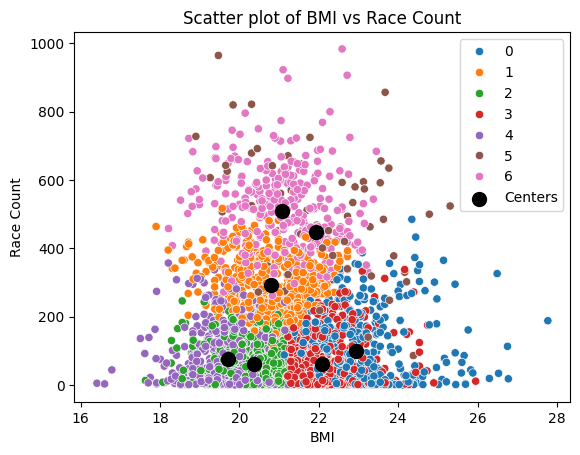

In [27]:
sns.scatterplot(data=small_cyc_df, x='bmi', y='race_count', hue='cluster', palette='tab10')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=1, label='Centers')
plt.title('Scatter plot of BMI vs Race Count')
plt.xlabel('BMI')
plt.ylabel('Race Count')
plt.legend()
plt.show()

Grafichino un po' meglio che ve devo di'???

C'e' ancora da togliere gli outlier dei punteggi che rompono tutto